##### Import modules:

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}
from pylab import rcParams

import time

rcParams['figure.figsize'] = 14,6

plt.style.use('ggplot')


%matplotlib inline

##### Loading data:

In [3]:
df = pd.read_csv('BaynesSoundMooring_5mbss_ConductivityTemperatureDepth_20200117T030000Z_20200119T235959Z-NaN.csv',skipinitialspace=True)
df.rename(columns={df.columns[0]: 'UTC time', df.columns[1]: 'Conductivity',df.columns[15]: 'Temperature'},inplace=True)
X = df[['Conductivity','Temperature']].values

##### Visualisation:

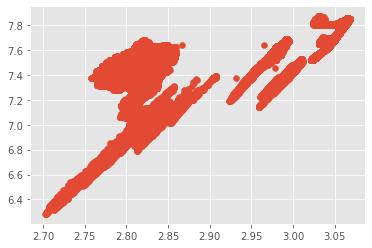

In [3]:
plt.scatter(df['Conductivity'],df['Temperature'])

###### Basic Stats:

In [4]:
N = X.shape[0]
mean = (1 / N) * np.sum(X, axis=0)
x_ = X - mean # Broadcast
var = (1 / N) * (np.dot(x_.T, x_))
print("Mean : {}".format(mean))
print("Mean with Numpy : {}".format(np.mean(X, axis=0)))

print("Variance : {}".format(var))
print("Variance with Numpy : {}".format(np.cov(X.T)))

Mean : [2.93211171 7.47042625]
Mean with Numpy : [2.93211171 7.47042625]
Variance : [[0.01101829 0.0247726 ]
 [0.0247726  0.08967184]]
Variance with Numpy : [[0.01101834 0.0247727 ]
 [0.0247727  0.08967221]]


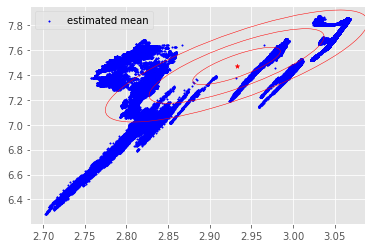

In [5]:
from matplotlib.patches import Ellipse


fig, ax = plt.subplots()

eig_values, eig_vectors = np.linalg.eig(var)

for i in range(1, 4):
    ellipse = Ellipse(xy=(mean[0], mean[1]), width=np.sqrt(eig_values[0]) * i,
                  height=np.sqrt(eig_values[1]) * i,
                  angle=np.rad2deg(np.arctan2(eig_vectors[1, 0], eig_vectors[0, 0])),
                 facecolor='none', edgecolor='red')
    ax.add_artist(ellipse)
# plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], color='blue', s=2)
plt.scatter(mean[0], mean[1], marker='*', color='red', s=20)
plt.legend(['estimated mean'])



##### K-Means Clustering 

Text(0, 0.5, 'Inertia')

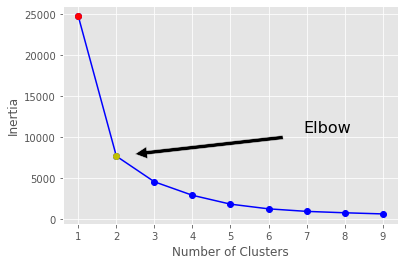

In [6]:
from sklearn.cluster import KMeans
inertias = []

for cluster_number in range(1,10):
  kmeans = KMeans(n_clusters=cluster_number, random_state=42).fit(X)
  inertias.append(kmeans.inertia_)  

#plot Inertia
plt.plot(range(1,10), inertias, 'bo-')
plt.annotate('Elbow',xy=(2, inertias[1]),
             xytext=(0.75, 0.50),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
)
plt.plot(1, inertias[0], 'ro-')
plt.plot(2, inertias[1], 'yo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

In [7]:
kmeans = KMeans(n_clusters = 2, init = "k-means++", random_state = 42)
s = time.time()

y_kmeans = kmeans.fit_predict(X)

e = time.time()
print("Training time = {}".format(e - s))

Training time = 1.46199631690979


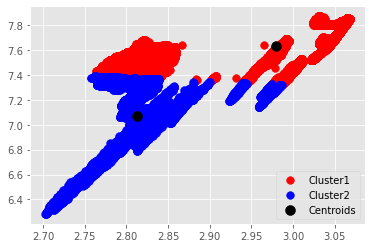

In [8]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 60, c = 'red', label = 'Cluster1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 60, c = 'blue', label = 'Cluster2')
#plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 60, c = 'green', label = 'Cluster3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')
plt.legend() 

plt.show()


In [9]:
from sklearn.mixture import GaussianMixture
n_clusters = 2
gmm_model = GaussianMixture(n_components=n_clusters)

s1 = time.time()

y_gm = gmm_model.fit_predict(X)

e1 = time.time()
print("Training time = {}".format(e1 - s1))

Training time = 2.286956548690796


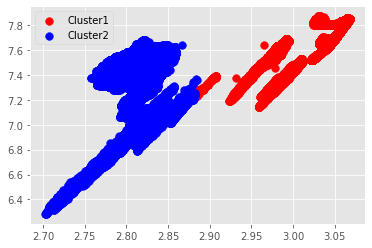

In [10]:
plt.scatter(X[y_gm == 0, 0], X[y_gm == 0, 1], s = 60, c = 'red', label = 'Cluster1')
plt.scatter(X[y_gm == 1, 0], X[y_gm == 1, 1], s = 60, c = 'blue', label = 'Cluster2')
plt.legend() 

plt.show()


In [11]:
from sklearn.cluster import MiniBatchKMeans

from joblib import cpu_count


In [3]:
from sklearn.cluster import KMeans
t0 = time.time()

elkan_kmeans = KMeans(n_clusters=2, random_state=42 ,algorithm='elkan').fit_predict(X)
t_mini_batch = time.time() - t0
print("Time taken to Elkan %0.2f seconds" % t_mini_batch)


Time taken to Elkan 1.55 seconds


In [12]:
mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters= 2,
    batch_size=256 * cpu_count(),
    n_init=2,
    max_no_improvement=2,
    verbose=0,
    random_state=0,
)
t0 = time.time()
y_mb = mbk.fit_predict(X)
t_mini_batch = time.time() - t0
print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)


Time taken to run MiniBatchKMeans 0.58 seconds


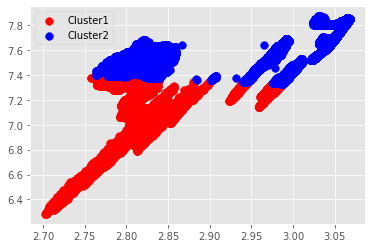

In [13]:
plt.scatter(X[y_mb == 0, 0], X[y_mb == 0, 1], s = 60, c = 'red', label = 'Cluster1')
plt.scatter(X[y_mb == 1, 0], X[y_mb == 1, 1], s = 60, c = 'blue', label = 'Cluster2')
plt.legend() 

plt.show()


In [14]:
from sklearn.cluster import MiniBatchKMeans
from timeit import timeit
run_time_full = []
run_time_mini=[]
run_time_elkan = []
max_k = 10
for k in range(1, max_k):
    kmeans_ = KMeans(n_clusters=k, random_state=42,algorithm='full')
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    elkan_kmeans = KMeans(n_clusters=k, random_state=42 ,algorithm='elkan')
    run_time_full.append(timeit("kmeans_.fit(X)", number=10, globals=globals()))
    run_time_mini.append(timeit("minibatch_kmeans.fit(X)", number=10, globals=globals()))
    run_time_elkan.append(timeit("elkan_kmeans.fit(X)", number=10, globals=globals()))

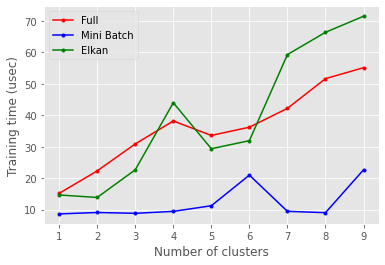

In [15]:
plt.clf()
plt.plot(range(1,max_k),run_time_full, 'r.-' , label='Full' )
plt.plot(range(1,max_k),run_time_mini, 'b.-' , label = 'Mini Batch' )
plt.plot(range(1,max_k),run_time_elkan, 'g.-', label = 'Elkan' )
plt.xlabel('Number of clusters')
plt.ylabel('Training time (usec)')
plt.legend(loc='upper left')
plt.show()

In [16]:
elkan_kmeans = KMeans(n_clusters=2, random_state=42 ,algorithm='elkan')
y_el =elkan_kmeans.fit_predict(X)

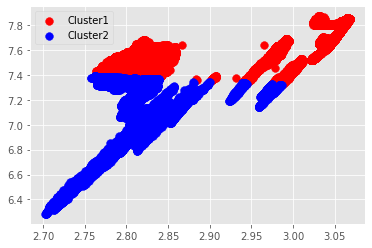

In [17]:
plt.scatter(X[y_el == 0, 0], X[y_el == 0, 1], s = 60, c = 'red', label = 'Cluster1')
plt.scatter(X[y_el == 1, 0], X[y_el == 1, 1], s = 60, c = 'blue', label = 'Cluster2')
plt.legend() 

plt.show()


In [18]:
from sklearn.neighbors import NearestNeighbors # importing the library
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(X) # fitting the data to the object
distances,indices=nbrs.kneighbors(X) # finding the nearest neighbours

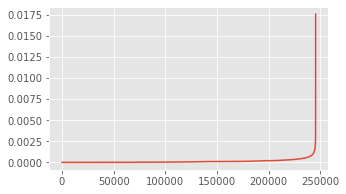

In [19]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

In [4]:
from sklearn.cluster import DBSCAN
t0 = time.time()
db = DBSCAN(eps = 0.0001, min_samples = 57).fit(X) # fitting the model

t_mini_batch = time.time() - t0
print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)


labels = db.labels_
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Time taken to run MiniBatchKMeans 4.80 seconds
Estimated number of clusters: 2
Estimated number of noise points: 245277


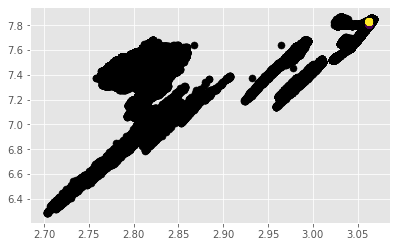

In [21]:
# Separate outliers from clustered data
outliers_X = X[labels == -1]
clusters_X = X[labels != -1]

colors_clusters = labels[labels != -1]
colors_outliers = 'black'

# plot clusters and outliers
fig = plt.figure()
ax = fig.add_axes([.1, .1, 1, 1])

ax.scatter(outliers_X[:,0],outliers_X[:,1], c = colors_outliers,s =50)
ax.scatter(clusters_X[:,0],clusters_X[:,1], c = colors_clusters,s =50)

In [26]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=150, min_samples=20).fit(X)
labels = clusterer.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 192
Estimated number of noise points: 46321


In [6]:
import hdbscan

t0 = time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=1175).fit(X)

t_mini_batch = time.time() - t0
labels = clusterer.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)   

Estimated number of clusters: 14
Estimated number of noise points: 26439


#### Exploratory anomalies detection analysis


In [10]:
con = X[:,0]
tem = X[:,1]

dataset = pd.DataFrame()
dataset['Conductivity'] = con.tolist()
dataset['Temperature'] = tem.tolist()

dataset.head(3)

,Conductivity,Temperature
0,2.97789,7.3472
1,2.97792,7.3472
2,2.97787,7.3470


##### Applying scaling data transformations

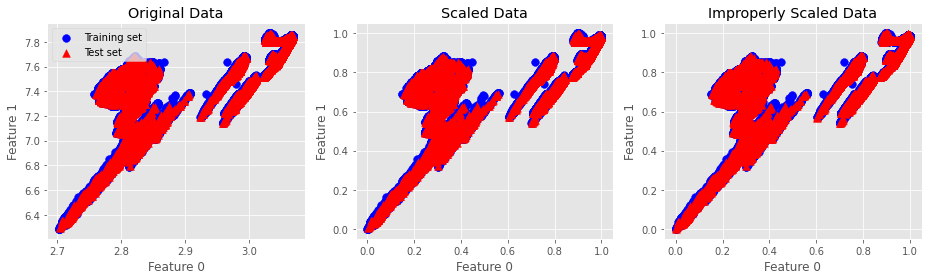

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# split it into training and test set
X_train, X_test = train_test_split(X, random_state=5, test_size=.1)

fig, axes = plt.subplots(1, 3, figsize=(13, 4))
# plot the training and test set
axes[0].scatter(X_train[:, 0], X_train[:, 1],
                c='b', label="Training set", s=60)
axes[0].scatter(X_test[:, 0], X_test[:, 1], marker='^',
                c='r', label="Test set", s=60)
axes[0].legend(loc='upper left')
axes[0].set_title("Original Data")
axes[0].grid(True)

# scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# visualize the properly scaled data
axes[1].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1],
                c='b', label="Training set", s=60)
axes[1].scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], marker='^',
                c='r', label="Test set", s=60)
axes[1].set_title("Scaled Data")
axes[1].grid(True)

# rescale the test set separately
# so that test set min is 0 and test set max is 1
# DO NOT DO THIS! For illustration purposes only
test_scaler = MinMaxScaler()
test_scaler.fit(X_test)
X_test_scaled_badly = test_scaler.transform(X_test)

# visualize wrongly scaled data
axes[2].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1],
                c='b', label="training set", s=60)
axes[2].scatter(X_test_scaled_badly[:, 0], X_test_scaled_badly[:, 1],
                marker='^', c='r', label="test set", s=60)
axes[2].set_title("Improperly Scaled Data")
axes[2].grid(True)

for ax in axes:
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
fig.tight_layout()

In [22]:
from sklearn.decomposition import PCA

# keep the first two principal components of the data
pca = PCA(n_components=2)

# fit PCA model to breast cancer data
pca.fit(X)

# transform data onto the first two principal components
X_pca = pca.transform(X)
print(f"Original shape: {X.shape}")
print(f"Reduced shape : {X_pca.shape}")

Original shape: (245404, 2)
Reduced shape : (245404, 2)


In [27]:
def cluster_plots(set1, colours = 'gray', 
                  title = 'Dataset'):
    fig,ax = plt.subplots(1, 1)
    fig.set_size_inches(6, 3)
    ax.set_title(title,fontsize=14)
    ax.scatter(set1[:, 0], set1[:, 1],s=8,lw=0,c= colours)
    fig.tight_layout()
    plt.show()

Dataset:
Number of Noise Points: 245277 (245404)


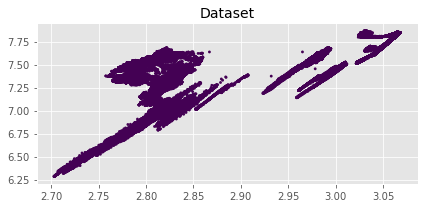

In [33]:
from sklearn import cluster, mixture


# implenting DBSCAN
dbscan_dataset = cluster.DBSCAN(eps=0.0001, min_samples=57, metric='euclidean').fit_predict(X)
# noise points are assigned -1
print('Dataset:')
print("Number of Noise Points: ",sum(dbscan_dataset==-1)," (",len(dbscan_dataset),")",sep='')
cluster_plots(X, dbscan_dataset)

Dataset
Cluster 0: 176227
Cluster 1: 69177


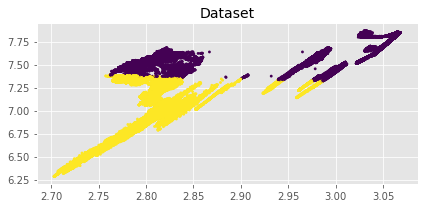

In [38]:
kmeans_dataset = cluster.KMeans(n_clusters=2, max_iter=300, 
                                 init='k-means++',n_init=10).fit_predict(X)
print('Dataset')
print(*["Cluster "+str(i)+": "+ str(sum(kmeans_dataset==i)) for i in range(2)], sep='\n')
cluster_plots(X,kmeans_dataset)

#### K-Means

Based on absolutely no empirical evidence (the threshold for baseless assertions is much lower in blogging than academia), k-means is probably the most popular clustering algorithm of them all. The algorithm itself is relatively simple: Starting with a pre-specified number of cluster centres (which can be distributed randomly or smartly (see kmeans++)), each point is initally assigned to its nearest centre. In the next step, for each segment, the centres are moved to the centroid of the clustered points. The points are then reassigned to their nearest centre. The process is repeated until moving the centres derives little or no improvement (measured by the within cluster sum of squares- the total squared distance between each point and its cluster centre). 


Variations on the k-means algorithm include k-medoids and k-medians, where centroids are updated to the medoid and median of existng clusters, repsectively. Note that, under k-medoids, cluster centroids must correspond to the members of the dataset. Alogorithms in the k-means family are sensitive to the starting position of the cluster centres, as each method converges to local optima, the frequency of which increase in higher dimensions.

###### Expectation Maximisation (EM)
This technique is the application of the general expectation maximisation (EM) algorithm to the task of clustering. It is conceptually related and visually similar to k-means  Where k-means seeks to minimise the distance between the observations and their assigned centroids, EM estimates some latent variables (typically the mean and covariance matrix of a mutltinomial normal distribution (called Gaussian Mixture Models (GMM))), so as to maximise the log-likelihood of the observed data. Similar to k-means, the algorithm converges to the final clustering by iteratively improving its performance (i.e. reducing the log-likelihood). However, again like k-means, there is no guarantee that the algorithm has settled on the global minimum rather than local minimum (a concern that increases in higher dimensions).

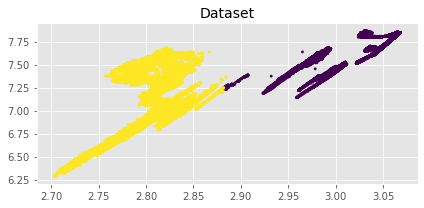

In [44]:
em_dataset = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(X)
cluster_plots(X, em_dataset.predict(X))

In [ ]:
from matplotlib import gridspec
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import normalize, StandardScaler

min_samples = 155

# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Normalizing the data so that the data
# approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)

# Converting the numpy array into a pandas DataFrame
X_normalized = pd.DataFrame(X_normalized)

# Compute OPTICS
db = OPTICS(min_samples = min_samples).fit(X_normalized)


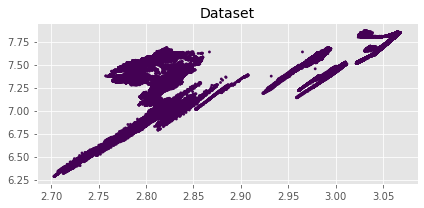

In [61]:
from sklearn.cluster import Birch

birch = Birch(n_clusters=2).fit(X)

cluster_plots(X, birch.predict(X))

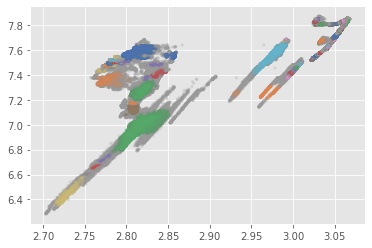

In [8]:
import seaborn as sns
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=150).fit(X) # the smallest size grouping that you wish to consider a cluster
pal = sns.color_palette('deep', 150)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_,clusterer.probabilities_)]
plt.scatter(X[:,0], X[:,1], c=colors, **plot_kwds);

In [34]:
from sklearn.model_selection import RandomizedSearchCV
import hdbscan
from sklearn.metrics import make_scorer

SEED = 42
np.random.seed(SEED)  # set the random seed as best we can

logging.captureWarnings(True)
hdb = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(X)

# specify parameters and distributions to sample from
param_dist = {'min_samples': [100,120,140,160,180,200],
              'min_cluster_size':[100,200,300,400,500,600],  
              'cluster_selection_method' : ['eom','leaf'],
              'metric' : ['euclidean','manhattan'] 
             }

#validity_scroer = "hdbscan__hdbscan___HDBSCAN__validity_index"
validity_scorer = make_scorer(hdbscan.validity.validity_index,greater_is_better=True)


n_iter_search = 20
random_search = RandomizedSearchCV(hdb
                                   ,param_distributions=param_dist
                                   ,n_iter=n_iter_search
                                   ,scoring=validity_scorer 
                                   ,random_state=SEED)

random_search.fit(X)


print(f"Best Parameters {random_search.best_params_}")
print(f"DBCV score :{random_search.best_estimator_.relative_validity_}")

Best Parameters {'min_samples': 160, 'min_cluster_size': 200, 'metric': 'manhattan', 'cluster_selection_method': 'leaf'}
DBCV score :0.1623729433436164


In [39]:
import hdbscan
clust  = hdbscan.HDBSCAN(min_samples= 150, min_cluster_size=300, metric='manhattan', cluster_selection_method= 'eom').fit(X)

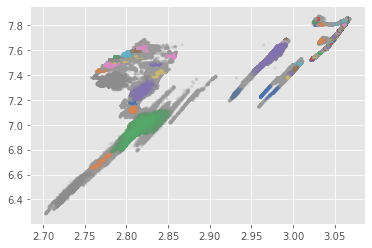

In [37]:
pal = sns.color_palette('deep', 100)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clust.labels_,clust.probabilities_)]
plt.scatter(X[:,0], X[:,1], c=colors, **plot_kwds);

In [47]:
labels = clust.labels_
clustered = (labels >= 0)

cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ['cluster','count']
print(cnts.sort_values(['cluster']))

    cluster  count
3        -1  27408
32        0    761
9         1   4195
34        2    714
38        3    607
24        4   1124
20        5   1311
31        6    788
36        7    648
17        8   1911
5         9   7252
11       10   3499
19       11   1554
1        12  34784
46       13    323
22       14   1186
0        15  59681
39       16    592
35       17    693
27       18    984
40       19    524
42       20    495
16       21   2047
29       22    892
13       23   2568
41       24    508
8        25   4279
12       26   3315
45       27    370
26       28   1038
14       29   2416
21       30   1231
33       31    742
10       32   3942
37       33    619
15       34   2230
44       35    379
30       36    880
2        37  31363
43       38    475
25       39   1100
7        40   4384
28       41    959
18       42   1748
4        43  20502
23       44   1132
6        45   5251
